# Discrete Choice Problem

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from csrank import FATEDiscreteChoiceFunction

Using TensorFlow backend.


## The Medoid DC Problem

In the medoid problem the goal of the discrete choice algorithms for the medoid problem is to find the most central object for the given set.
This problem is inspired by solving the task of finding a good representation of the given data using the most central point of the data points

We will generate a random dataset where each instance contains 5 objects and 2 features for easy plotting.

In [2]:
from csrank import DiscreteChoiceDatasetGenerator
seed = 123
n_train = 10000
n_test = 10000
n_features = 2
n_objects = 5
gen = DiscreteChoiceDatasetGenerator(dataset_type='medoid', random_state=seed,
                                n_train_instances=n_train,
                                n_test_instances=n_test,
                                n_objects=n_objects,
                                n_features=n_features)

In [3]:
X_train, Y_train, X_test, Y_test = gen.get_single_train_test_split()

Let us plot a random instance. The medoid is marked as M.

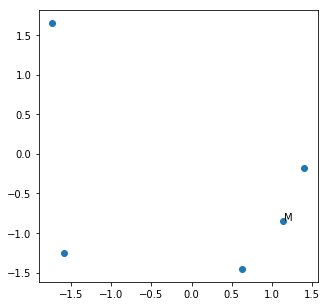

In [4]:
def get_name(d):
    if d ==0:
        return ""
    else:
        return "M"
fig, ax = plt.subplots(figsize=(5,5))
inst = np.random.choice(n_train)
ax.scatter(X_train[inst][:, 0], X_train[inst][:, 1])
for i in range(n_objects):
    ax.text(X_train[inst, i, 0]+0.01,
            X_train[inst, i, 1]+0.01,
            s=get_name(int(Y_train[inst, i])))

## The FATE network
The first-aggregate-then-evaluate approach learns an embedding of each object and then aggregates that into a _context_:
\begin{equation}
	\mu_{C(\vec{x})} = \frac{1}{|C(\vec{x})|} \sum_{\vec{y} \in C(\vec{x})} \phi(\vec{y})
\end{equation}
and then scores each object $\vec{x}$ using a generalized utility function $U (\vec{x}, \mu_{C(\vec{x})})$

In [5]:
from keras.optimizers import SGD
from csrank import FATEObjectRanker
from csrank.losses import smooth_rank_loss
fate = FATEObjectRanker(
    n_object_features=n_features,
    loss_function=smooth_rank_loss,
    optimizer=SGD(lr=1e-4, nesterov=True, momentum=0.9))

We will run the training for only 10 epochs to get an idea of the convergence:

In [6]:
fate.fit(X_train, Y_train, verbose=True, epochs=10)

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 7s 790us/step - loss: 11.3605 - zero_one_rank_loss_for_scores_ties: 2.0293 - val_loss: 11.2111 - val_zero_one_rank_loss_for_scores_ties: 1.7210
Epoch 2/10
9000/9000 [==============================] - 1s 116us/step - loss: 11.1619 - zero_one_rank_loss_for_scores_ties: 1.6179 - val_loss: 11.1051 - val_zero_one_rank_loss_for_scores_ties: 1.5140
Epoch 3/10
9000/9000 [==============================] - 1s 99us/step - loss: 11.0700 - zero_one_rank_loss_for_scores_ties: 1.4800 - val_loss: 11.0183 - val_zero_one_rank_loss_for_scores_ties: 1.4280
Epoch 4/10
9000/9000 [==============================] - 1s 107us/step - loss: 10.9863 - zero_one_rank_loss_for_scores_ties: 1.3791 - val_loss: 10.9573 - val_zero_one_rank_loss_for_scores_ties: 1.3700
Epoch 5/10
9000/9000 [==============================] - 1s 90us/step - loss: 10.9226 - zero_one_rank_loss_for_scores_ties: 1.3129 - val_loss: 10.8968 - v

In [7]:
scores = fate.predict_scores(X_test)

In [8]:
from csrank.metrics_np import categorical_accuracy_np
from keras import backend as K
categorical_accuracy_np(Y_test, scores)

0.005

Not converged yet, but let us visualize the scores it assigns to test instances:

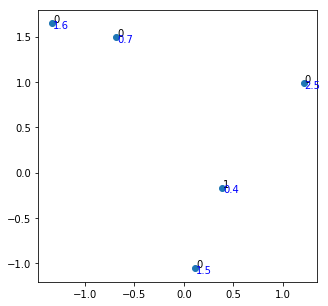

In [12]:
fig, ax = plt.subplots(figsize=(5,5))
inst = np.random.choice(n_test)
ax.scatter(X_test[inst][:, 0], X_test[inst][:, 1])
for i in range(n_objects):
    ax.text(X_test[inst, i, 0]+0.01,
            X_test[inst, i, 1]+0.01,
            s=int(Y_test[inst, i]))
    ax.text(X_test[inst, i, 0]+0.01,
            X_test[inst, i, 1]-0.05,
            s='{:.1f}'.format(scores[inst][i]),
            color='b')